# 2.1 - Classification & Simple Logistic Regression

## Classification analysis

The aim of regression analysis is to create a model to estimate an unknown response from any given set of features, based of known data. There, this response can be any real number in a given interval. 

However, there are applications in which the response is qualitative, and thus has a fixed number of possible values. In other words, there is a finite number of possible values (classes) for the response variable. For a given set of features, the estimation of which of these classes the features belong to is done through classification analysis.

One can convert qualitative classes into numerical ones (e.g. "Yes" => 1, "No" => 0) but this comes with problems. For instance, difference choices of conversion (all equally valid) lead to different models, and then also the interpretation of these models may be complicated.

## Logistic Regression

__Input__: Dataset $((x_1, y_1), (x_2, y_2), \cdots, (x_N, y_N))$ with a single feature (aka predictor, or covariate) and a *qualitative* response variable.

__Purpose__: Find the "best" logistic function that describes the data. 

__Approach__: Usually, "best" means to maximize the likelihood of each prediction being correct.

__Assumptions__: The probabilities of $y$ belong to each class follow a logistic function (or close to one). 

__Hyperparameters__: None. 

Since we usually want to deal with continuous variables, we change the approach we had for regression problems. There, for linear regression, we directly estimate the value of the response variable, since it itself is continuous. For classification problems, this is not the case. So, instead, we estimate the probability that the response variable will belong to any given class! 

More concretely, given a set of inputs $X$ with a corresponding response $y$, we do not estimate $y$ directly, but instead compute the probabilities $\mathcal{P}(y=y_i| X)$.

We start with the simplest case of two classes, which we can denote as $y_0 = 0$ and $y_1 = 1$. The problem then becomes estimating just one of them, say $\mathcal{P}(y = 1 | X) \equiv p(X)$. Our model needs to chosen so that its continuously varying estimates are real probabilities i.e. belonging to $[0,1]$. A good function that does this is the logistic function:

$$ p(x) = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}}  = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}$$

The coefficients can be estimated by maximizing the likelihood that the model's estimates are correct (i.e. that the estimate for each data point is as close to the real data as possible). We define this likelihood as 
$$ \begin{align}
l(\beta_0, \beta_1) &= \mathcal{P}(\text{p estimates are correct i.e. matching the data})\\
                    &=  \mathcal{P}( p(y_i = 1 | x_i) = 1 ) . \mathcal{P}(p(y_i = 0 | x_i) = 0) \\
                    &= \Pi_{i, y_i =1} p(x_i) \; \Pi_{i', y_{i'}=0} [1-p(x_{i'})] \\
                    &= p^y (1-p)^{1-y},
\end{align}$$

and then use numerical methods to find $\hat{\beta_0}$ and $\hat{\beta_1}$ that maximze $l$.

Useful quantities: $ \mathrm{Odds} \equiv \frac{p(x)}{p(!x} = \frac{p(x)}{1-p(x)} = e^{\beta_0 + \beta_1 x}$. If $p(x)$ is low, odds are close to $0$, if $p(x)$ is high, odds approach infinity.

Log of odds is a linear term!

### Estimating the parameters
We can numerically estiamte the parameters by using gradient descent. For this, we need to define a loss function and its derivative. The optimization apparently works best is the cost function is written as a sum, instead of a problem. Also gradient descent minimizes the cost function. Since we want to maximize the likelihood, which is a product, we can define a cost function $$\mathcal{L}(p|y) = - \frac{1}{N} \log l(p|y) $$ that is the negative log-likelihood, where $N$ is the number of data points. This normalization becomes clearer later, but it used to make the likelihood not depend on the number of points. Maximizing the likelihood is equivallent to minimizing the cost function. Through some algebra, we arrive at 
$$ \mathcal{L}(p|y) = - \frac{1}{N} \sum_{i=1}^N [y_i \log(p_i) + (1-y_i)\log(1-p_i)]$$.

This is also called the cross-entropy loss function.

Now, for the algorithm, we need the derivative $\frac{d\mathcal{L}}{d\beta_1}$. More algebra leads to 
$$\frac{d\mathcal{L}}{d\beta_1} = -\frac{1}{N} [p - y] x$$

The algorithm for gradient descent then updates the weights by always descending the gradient (moving against it), meaning the cost function is always decreasing. Since the cross-entropy functoin is convex, it is guaranteed to have at most only one minimum, so the algorithm is guaranteed to work! In general, for weights $\theta$ and a learning parameter $\eta$ and loss function $L$, the formula to follow is:

$$ \theta^{i+1} = \theta^i - \eta \nabla L(f(x; \theta), y)) $$.

So if one has two parameters on top of the intercept, the gradient can be written as 

$$ \nabla_{b,w}L = \begin{bmatrix} \frac{\partial L}{\partial b}  \\ \frac{\partial L}{\partial w_1} \\ \frac{\partial L}{\partial w_2}  \end{bmatrix} = \begin{bmatrix} (p - y) \\ (p - y)x_1 \\ (p - y)x_2  \end{bmatrix}
  $$

For more than one data point, the gradient is the average of the individual gradients.

## Code
I implement a simple version of the gradient descent and then apply it in a simple synthetic example. I also compare with sklearn. I want the simplest examples, so I'm not even separating the dataset into train and test datasets!

In [110]:
import numpy as np
class LogisticRegressionManual:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        print(n_features)
        self.weights = np.zeros(n_features)
        prev_cost = float('inf')
        
        for _ in range(self.max_iter):
            predictions = self.predict_proba(X)

            
            # Calculate the gradient
            #gradient = np.dot(X.T, (predictions - y)) / n_samples
            gradient = np.dot((predictions - y).T, X) / n_samples
            
            # Update weights
            self.weights -= self.learning_rate * gradient
            
            # Compute current cost
            cost = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

            #print(f'cost = {cost}, norm(gradient) = {np.linalg.norm(gradient)}, gradient = {gradient}, weights = {self.weights}') 
            # Check for convergence
            if abs(cost - prev_cost) < self.tol:
                break
            
            prev_cost = cost
        
    def predict_proba(self, X):
        z = np.dot(X, self.weights) ## X is (n_samples, n_features), weights is (n_features) so z is (n_samples)
        probabilities = self.sigmoid(z)
        return probabilities

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        predictions = (probabilities >= threshold).astype(int) 
        return predictions

from sklearn.linear_model import LogisticRegression

def logistic_regression_sklearn(X_vals, y_binary):
    model = LogisticRegression()
    model.fit(X_vals, y_binary)
    predictions = model.predict(X_vals)
    
    coefficients = model.coef_
    intercept = model.intercept_
    probabilities_model_coeffs = logistic(x_vals, intercept, coefficients[0])
    
    #probabilities_model = model.predict_proba(X_vals)
    #predictions = (probabilities_model[:, 1] >= 0.5).astype(int) #if you want to change the threshold
    accuracy = model.score(X_vals, y_binary)
    print(f"Accuracy: {accuracy}")
    
    return predictions, probabilities_model_coeffs, coefficients, intercept

def plot_logistic_regression(x_vals, X_vals, y_vals, y_binary, probabilities_model, predictions):
    plt.scatter(x_vals, y_vals, label='original probabilities')
    plt.scatter(x_vals, probabilities_model, label='model probabilities')
    
    plt.scatter(x_vals, y_binary, color='red', label = 'true values')
    plt.scatter(X_vals, predictions, color='green', label = 'estimated values')
    plt.legend()


In [118]:
# Generate example following Logistic Function
import random
import numpy as np
import matplotlib.pyplot as plt

def logistic(x, true_intercept, true_slope):
    exp_term = np.exp(true_intercept + true_slope * x)
    return exp_term / (1 + exp_term)

x_min = 1; x_max = 90; num_xs = 1000

x_vals = np.array([random.randint(x_min, x_max) for _ in range(num_xs)])  #ages
X_vals = x_vals.reshape(-1, 1)


true_intercept = -2
true_slope = 0.05

y_vals = logistic(x_vals, true_intercept, true_slope) #generate continuous values
y_binary = np.array([1 if y > 0.5 else 0 for y in y_vals]) # discretize into two classes
X_vals_intercept = np.column_stack((np.ones(X_vals.shape[0]), X_vals))

2
Accuracy = 0.978
Intercept = -6.922771808418476, Coefficients = 0.17877770693548342
[ 0.01413765 -0.00033622]


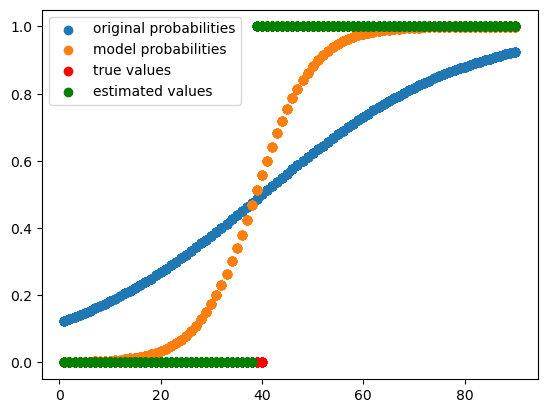

In [119]:
# Gradient descent 
learning_rate = 0.005
max_iter = 40000
tol = 1e-6
model = LogisticRegressionManual(learning_rate, max_iter, tol)
model.fit(X_vals_intercept, np.array(y_binary))

probabilities_manual = model.predict_proba(X_vals_intercept)
predictions_manual = (probabilities_manual >= 0.5).astype(int) 

num_correct = np.mean(np.array(predictions_manual) == np.array(y_binary))
print(f'Accuracy = {num_correct}')

beta_est_manual = model.weights
print(f'Intercept = {beta_est_manual[0]}, Coefficients = {beta_est_manual[1]}')
plot_logistic_regression(x_vals, X_vals, y_vals, y_binary, probabilities_manual, predictions_manual)

gradient = np.dot((probabilities_manual - y_binary).T, X_vals_intercept) / X_vals_intercept.shape[0]
print(gradient)

Accuracy: 1.0
Intercept = [-109.55148975], Coefficients = [[2.71125057]]
[0.]


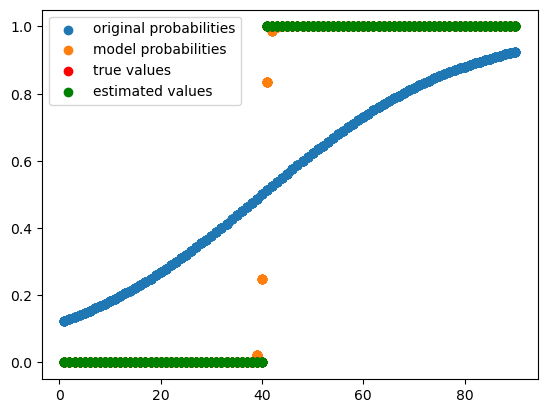

In [109]:
#sklearn
predictions, probabilities_model_coeffs, coefficients, intercept = logistic_regression_sklearn(X_vals, y_binary)
print(f'Intercept = {intercept}, Coefficients = {coefficients}')

plot_logistic_regression(x_vals, X_vals, y_vals, y_binary, probabilities_model_coeffs, predictions)

gradient = np.dot((predictions - y_binary).T, X_vals) / X_vals.shape[0]
print(gradient)

Accuracy: 1.0
Intercept = [-82.94873054], Coefficients = [[1.30487018]]


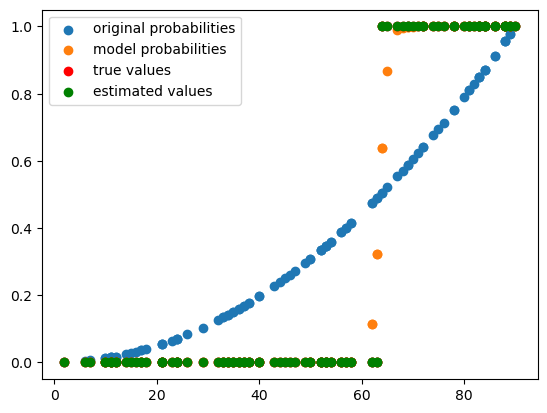

In [21]:
# Example not following Logistic Function
import random
x_min = 1; x_max = 90; num_xs = 100
x_vals = np.array([random.randint(x_min, x_max) for _ in range(num_xs)])  #ages
X_vals = x_vals.reshape(-1, 1)

y_vals = (1/x_max**2)*x_vals**2 #so that y=1 at x=x_max and y=0 at x=0
y_binary = [1 if y > 0.5 else 0 for y in y_vals]

predictions, probabilities_model_coeffs, coefficients, intercept = logistic_regression_sklearn(X_vals, y_binary)
print(f'Intercept = {intercept}, Coefficients = {coefficients}')

plot_logistic_regression(x_vals, X_vals, y_vals, y_binary)